In [ ]:
import json
from datetime import timedelta

import geopandas as gpd
import numpy as np
import shapely
from matplotlib import pyplot as plt
from owslib.wms import WebMapService

import sentinelhub
from sentinelhub import CRS, BBox, Geometry, SentinelHubCatalog, SHConfig, WmsRequest, parse_time
from sentinelhub.api.statistical import SentinelHubStatistical
from sentinelhub.constants import RequestType
from sentinelhub.data_collections import DataCollection
from sentinelhub.data_utils import statistical_to_dataframe
from sentinelhub.download.sentinelhub_statistical_client import SentinelHubStatisticalDownloadClient

This notebook showcases the toolbox's capabilities in retrieving and analyzing historical environmental indicators. It serves as a foundational example of how the AgriDataValue toolbox can be used for long-term environmental change monitoring.

The notebook demonstrates the connection to Sentinel Hub services to access and process historical environmental indicators, particularly leveraging Bring Your Own COG (BYOC) collections. A key example used is the Vegetation Health Index (VHI), which provides insights into vegetation stress and drought conditions. A significant feature showcased is the ability to analyze data over extended historical periods (e.g., from 1985 to the present). This allows for the assessment of long-term trends in environmental conditions relevant to agricultural landscapes and CAP objectives.

The demonstrator includes methods for defining an AOI and extracting time-series statistics for indicators like VHI within that area. This enables quantitative analysis of how environmental conditions have evolved over decades.
The notebook also provides examples of how to visualize these long-term trends using time-series plots showing the fluctuation of indicators such as VHI year by year on spatial maps displaying the indicator values for selected years, allowing for a visual comparison of environmental states at different points in the historical record.

The workflow and capabilities demonstrated in this notebook are integral to the objectives of the CAP Monitoring toolbox. By enabling access to and analysis of historical environmental data, the toolbox provides crucial context for understanding current environmental states, assessing the long-term impacts of agricultural practices and climate change, and supporting data-driven decision-making for sustainable agriculture and CAP compliance.

This demonstrator illustrates a core component of the toolbox – the ability to ingest, process, and interpret historical datasets. It highlights the use of sentinelhub-py for robust data access and standard Python libraries for subsequent analysis and visualization, forming a key part of the toolbox's architecture.

# Utility functions 

In [2]:
def list_sentinelhub_configurations(config: SHConfig, collection_id: str) -> list[dict]:
    """
    List all configurations for a given collection.
    Args:
        config: SHConfig
        collection_id: str, BYOC collection ID for which the configurations are listed
    Returns:
        list: list of configurations
    """
    session = sentinelhub.SentinelHubSession(config=config)

    coll_id = collection_id.removeprefix("byoc-")
    request = sentinelhub.base.DownloadRequest(
        url=f"https://sh.dataspace.copernicus.eu/api/v2/configuration/instances?collectionId={coll_id}",
        request_type=RequestType.GET,
        use_session=True,
        headers={"content-type": "application/json;charset=utf-8"},
    )

    client = sentinelhub.SentinelHubDownloadClient(session=session)
    response = client.download([request], decode_data=False)[0]

    return json.loads(response.content.decode())

In [ ]:
config = SHConfig(profile="adv-demonstrator")
config.sh_base_url = "https://sh.dataspace.copernicus.eu"
config.sh_token_url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
catalog = SentinelHubCatalog(config=config)

# Get data 

In [4]:
aoi = (
    "MultiPolygon (((0.1934735202856874 41.862204100840259, 0.19333435235317373 41.86232299456581529,"
    " 0.19315790762176849 41.86259731511638904, 0.19298299844768915 41.86289706896998553, 0.19295955268427448"
    " 41.86293729124536611, 0.19277459943110034 41.86311693340326912, 0.19248146053032858 41.86331293061823544,"
    " 0.19224552512116022 41.86361407662933942, 0.19167708305901338 41.86416005088052827, 0.19156862441108211"
    " 41.864292932231983, 0.1915556423699234 41.86431701993191012, 0.19244601563971245 41.86478071044896154,"
    " 0.19318950678740796 41.86516272243473225, 0.19413785935672059 41.86564844096591287, 0.1943324079461429"
    " 41.8657536108882482, 0.19467035020663967 41.86539822298133373, 0.19504600002092923 41.86510048700640141,"
    " 0.196420565144315 41.86462254842476938, 0.19641080710075226 41.86476306891898247, 0.1963938683553236"
    " 41.86500733960439646, 0.19645959948316721 41.86483486549386868, 0.19664023590428159 41.86470149123041296,"
    " 0.1968753271905421 41.8646564372390273, 0.19698112797444467 41.864680725188542, 0.19707678102340495"
    " 41.86469738052667111, 0.19757055723744343 41.86451383604557464, 0.19590581728178671 41.86360912045829963,"
    " 0.19441975175372272 41.86276408904257806, 0.1934735202856874 41.862204100840259)))"
)

In [5]:
aoi = shapely.wkt.loads(aoi)

In [6]:
collections = catalog.get_collections()
collections = sorted(
    [collection for collection in collections if collection["id"].startswith("byoc")], key=lambda x: x["title"]
)

In [7]:
print("The following BYOC collections are available:")
for collection in collections:
    print(f"- {collection['title']} ({collection['id']})")

The following BYOC collections are available:
- 5 year projection indicator - Daily maximum near-surface air temperature (byoc-c338f78f-5d6d-4fca-bcf4-dbb5e14445ce)
- 5 year projection indicator - Daily minimum near-surface air temperature (byoc-0048de7c-41cc-47d2-921a-b0d6ff92fc87)
- 5 year projection indicator - Daily near-surface air temperature (byoc-3998c981-b733-45e7-a67e-2f44c3bf3d03)
- 5 year projection indicator - Daily-mean near-surface wind speed (byoc-10f4ef9d-626c-4bfb-9d46-02a93318c5b6)
- 5 year projection indicator - Near-surface relative humidity (byoc-fb5bec13-2de2-4ad3-a478-41c2106a519e)
- 5 year projection indicator - Near-surface specific humidity (byoc-7913e91a-586d-4a6e-ac83-e2a6303dd792)
- 5 year projection indicator - Precipitation (byoc-67d59500-44bf-4d55-8755-706dd91dbc91)
- 5 year projection indicator - Surface downwelling longwave radiation (byoc-fd491afa-d736-4e74-a0cd-2045ffc339be)
- 5 year projection indicator - Surface downwelling shortwave radiation (by

In [8]:
def plot_parcel_stats(df, ax, **plot_kwargs):
    ssp_band_cols = [x for x in df.columns if x.startswith("bands") and x.endswith("mean")]
    df = df[ssp_band_cols + ["collection"]].rename(columns={x: " ".join(x.split("_")[1:3]) for x in ssp_band_cols})
    df.melt(id_vars=["collection"]).plot(x="variable", y="value", ax=ax, **plot_kwargs)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
    ax.set_title(df.iloc[0]["collection"])

In [9]:
def construct_evalscript(bands):
    bands_output = str(bands).replace("'", '"')
    bands_input = str(bands + ["dataMask"]).replace("'", '"')
    bands_str_samples = str([f"samples.{x}" for x in bands]).replace("'", "")

    rgb_evalscript = f"""
//VERSION=3

function setup() {{
  return {{
    input: [
      {{
        bands: {bands_input}
      }}
    ],
    output: [
      {{
        id: "bands",
        bands: {bands_output},
        sampleType: SampleType.FLOAT32
      }},
      {{
        id: "dataMask",
        bands: 1
      }}
    ]
  }}
}}

function evaluatePixel(samples) {{
    return {{
      bands: {bands_str_samples},
      dataMask: [samples.dataMask]
    }};
}}
"""
    return rgb_evalscript

In [10]:
def collection_statistics(collection, pilot_geom):
    band_names = [x["name"] for x in collection["summaries"]["eo:bands"]]
    title = collection["title"]

    byoc_collection = DataCollection.define_byoc(collection["id"][5:])
    bands_evalscript = construct_evalscript(band_names)

    collection_requests = []

    lon, lat = pilot_geom.centroid.x, pilot_geom.centroid.y
    utm_crs = CRS.get_utm_from_wgs84(lon, lat)

    transform_function = CRS.WGS84.get_transform_function(utm_crs, always_xy=True)
    geometry = shapely.ops.transform(transform_function, pilot_geom)
    if geometry.area == 0:
        geometry = geometry.buffer(20)

    geom_utm = Geometry(geometry, utm_crs)
    interval_start, interval_end = collection["extent"]["temporal"]["interval"][0]

    interval_start = parse_time(interval_start)
    interval_end = parse_time(interval_end) + timedelta(days=1)

    request = SentinelHubStatistical(
        aggregation=SentinelHubStatistical.aggregation(
            evalscript=bands_evalscript,
            time_interval=(interval_start, interval_end),  # TODO
            aggregation_interval="P1D",
            resolution=(10, 10),
        ),
        input_data=[SentinelHubStatistical.input_data(byoc_collection)],
        geometry=geom_utm,
        config=config,
        data_folder="./data",
    )
    collection_requests.append(request)

    download_requests = [coll_request.download_list[0] for coll_request in collection_requests]
    client = SentinelHubStatisticalDownloadClient(config=config)
    collection_stats = client.download(download_requests)
    stats = statistical_to_dataframe(collection_stats)
    print(stats.columns)
    band_mean_cols = [x for x in stats.columns if x.startswith("bands_") and x.endswith("mean")]
    stats = stats[band_mean_cols + ["interval_from"]]
    stats["collection"] = title
    return stats

In [11]:
selected_collections = [c for c in collections if c["title"].startswith("historical") and "VHI" in c["title"]]

In [12]:
selected_collections

[{'stac_version': '1.0.0',
  'stac_extensions': ['https://stac-extensions.github.io/eo/v1.0.0/schema.json',
   'https://stac-extensions.github.io/raster/v1.0.0/schema.json'],
  'type': 'Collection',
  'id': 'byoc-b7a083e8-132d-4989-af77-70b9d9ddb526',
  'title': 'historical indicator - VHI',
  'description': 'historical indicator - VHI',
  'license': 'proprietary',
  'keywords': ['has_tiles_with_sensing_time'],
  'providers': [],
  'extent': {'spatial': {'bbox': [[-16.376822807,
      34.801991748,
      31.587190841,
      71.183760755]]},
   'temporal': {'interval': [['1985-01-01T00:00:00Z',
      '2025-01-01T00:00:00Z']]}},
  'summaries': {'eo:bands': [{'name': 'VHI'}],
   'raster:bands': [{'data_type': 'float32', 'nodata': -100}]},
  'links': [{'href': 'https://sh.dataspace.copernicus.eu/api/v1/catalog/1.0.0/',
    'rel': 'root',
    'type': 'application/json'},
   {'href': 'https://sh.dataspace.copernicus.eu/api/v1/catalog/1.0.0/collections/byoc-b7a083e8-132d-4989-af77-70b9d9ddb52

In [13]:
stats = [collection_statistics(c, aoi) for c in selected_collections[:1]]

Index(['bands_VHI_min', 'bands_VHI_max', 'bands_VHI_mean', 'bands_VHI_stDev',
       'bands_VHI_sampleCount', 'bands_VHI_noDataCount', 'interval_from',
       'interval_to', 'identifier'],
      dtype='object')


<Axes: xlabel='interval_from'>

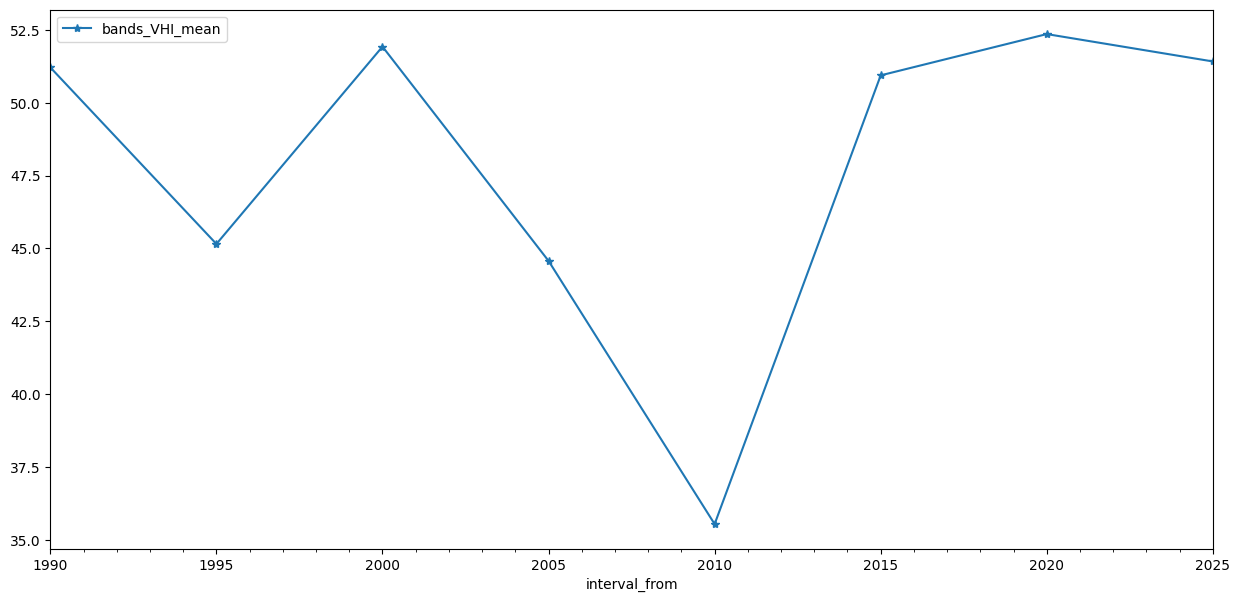

In [14]:
fig, ax = plt.subplots(figsize=(15, 7))
stats[0].plot(x="interval_from", y="bands_VHI_mean", ax=ax, marker="*")

# Visualize the data from the layer

In [15]:
def plot_image(image, bbox, ax, factor=1):
    """
    Utility function for plotting RGB images.
    """

    if np.issubdtype(image.dtype, np.floating):
        ax.imshow(np.minimum(image * factor, 1), extent=np.array(bbox.geometry.bounds[[0, 2, 1, 3]]))
    else:
        ax.imshow(image, extent=np.array(bbox.geometry.bounds)[[0, 2, 1, 3]])


def plot_image_with_zoom(
    img: np.ndarray, img_buffered: np.ndarray, bbox: BBox, bbox_buffered: BBox, ax, gdf: gpd.GeoDataFrame
) -> None:
    """
    Utility function for plotting RGB images.
    """

    img_extent_buffered = np.array(bbox_buffered.geometry.bounds)[
        [0, 2, 1, 3]
    ]  # Using pixel coordinates for this example
    img_extent = np.array(bbox.geometry.bounds)[[0, 2, 1, 3]]  # Using pixel coordinates for this example

    parcel_polygon = gdf.geometry.iloc[0]
    minx, miny, maxx, maxy = parcel_polygon.bounds
    ax.imshow(img_buffered, extent=img_extent_buffered)
    ax.set_title("Image with Parcel Location (Far Away)")

    gdf.plot(ax=ax, facecolor="None", edgecolor="black", linewidth=1)
    # ax.plot(*parcel_polygon.exterior.xy, color='red', linewidth=2, label='Parcel')

    ylim_inset = (miny, maxy)

    axins = ax.inset_axes(
        [0.6, 0.6, 0.38, 0.38],  # [left, bottom, width, height] in parent axes coordinates
        xlim=(minx, maxx),
        ylim=ylim_inset,
        xticklabels=[],
        yticklabels=[],
    )

    axins.imshow(img, extent=img_extent)

    # Plot the polygon in the inset axes
    gdf.plot(ax=axins, facecolor="None", edgecolor="black", linewidth=2)
    ax.indicate_inset_zoom(axins, edgecolor="black", alpha=0.7, lw=1.5)

In [19]:
def plot_image_with_statistics(statistics, collection, aoi, config):
    bbox = BBox(aoi.bounds, crs=CRS.WGS84)
    buffered_bbox = bbox.buffer(2000, relative=True)

    configuration = list_sentinelhub_configurations(config, collection["id"])[0]
    config.instance_id = configuration["id"]
    layer = list(WebMapService(f"https://sh.dataspace.copernicus.eu/ogc/wms/{configuration['id']}").contents.keys())[0]

    dates = [
        f"{year}-01-01"
        for year in range(
            1985,
            2026,
            5,
        )
    ]

    dates_data_original = {}
    dates_data_buffered = {}

    for date in dates:
        indicator_request_buffered = WmsRequest(
            data_collection=DataCollection.define_byoc(collection["id"][5:]),
            layer=layer,
            bbox=buffered_bbox,
            width=1024,
            config=config,
            time=date,
        )
        indicator_request_original = WmsRequest(
            data_collection=DataCollection.define_byoc(collection["id"][5:]),
            layer=layer,
            bbox=bbox,
            width=1024,
            config=config,
            time=date,
        )

        indicator_data_buffered = indicator_request_buffered.get_data()
        indicator_data_original = indicator_request_original.get_data()

        dates_data_buffered[date] = indicator_data_buffered
        dates_data_original[date] = indicator_data_original

    fig = plt.figure(figsize=(35, 10))
    fig.suptitle(collection["title"], fontsize=25)

    num_image_cols = len(dates_data_original)
    gs = fig.add_gridspec(2, num_image_cols)

    axs_images = [None for _ in range(num_image_cols)]
    for i in range(num_image_cols):
        axs_images[i] = fig.add_subplot(gs[0, i])
        # axs_images[1][i] = fig.add_subplot(gs[1, i],)
    ax_stats = fig.add_subplot(gs[1, :])  # Stats plot spans all columns in the third row

    gdf = gpd.GeoDataFrame(geometry=[aoi], crs=4326)

    for i, date in enumerate(dates):
        plot_image_with_zoom(
            dates_data_original[date][0], dates_data_buffered[date][0], bbox, buffered_bbox, axs_images[i], gdf
        )

        axs_images[i].set_title(date)
        axs_images[i].axis("off")

    # plot_parcel_stats(statistics, "45", ax_stats, label="SSP 4.5", color="blue", marker='o', fontsize=20, linewidth=3)
    statistics.plot(
        x="interval_from",
        y="bands_VHI_mean",
        ax=ax_stats,
        color="blue",
        marker="o",
        fontsize=25,
        linewidth=5,
        markersize=8,
    )
    ax_stats.set_title(f"Statistics for {collection['title']}", fontsize=30)
    ax_stats.legend()
    ax_stats.set_xlim("1983-01-01", "2027-01-01")
    ax_stats.set_xlabel("Year", fontsize=30)
    ax_stats.set_ylabel("Vegetation Health Index", fontsize=30)
    ax_stats.grid(True)

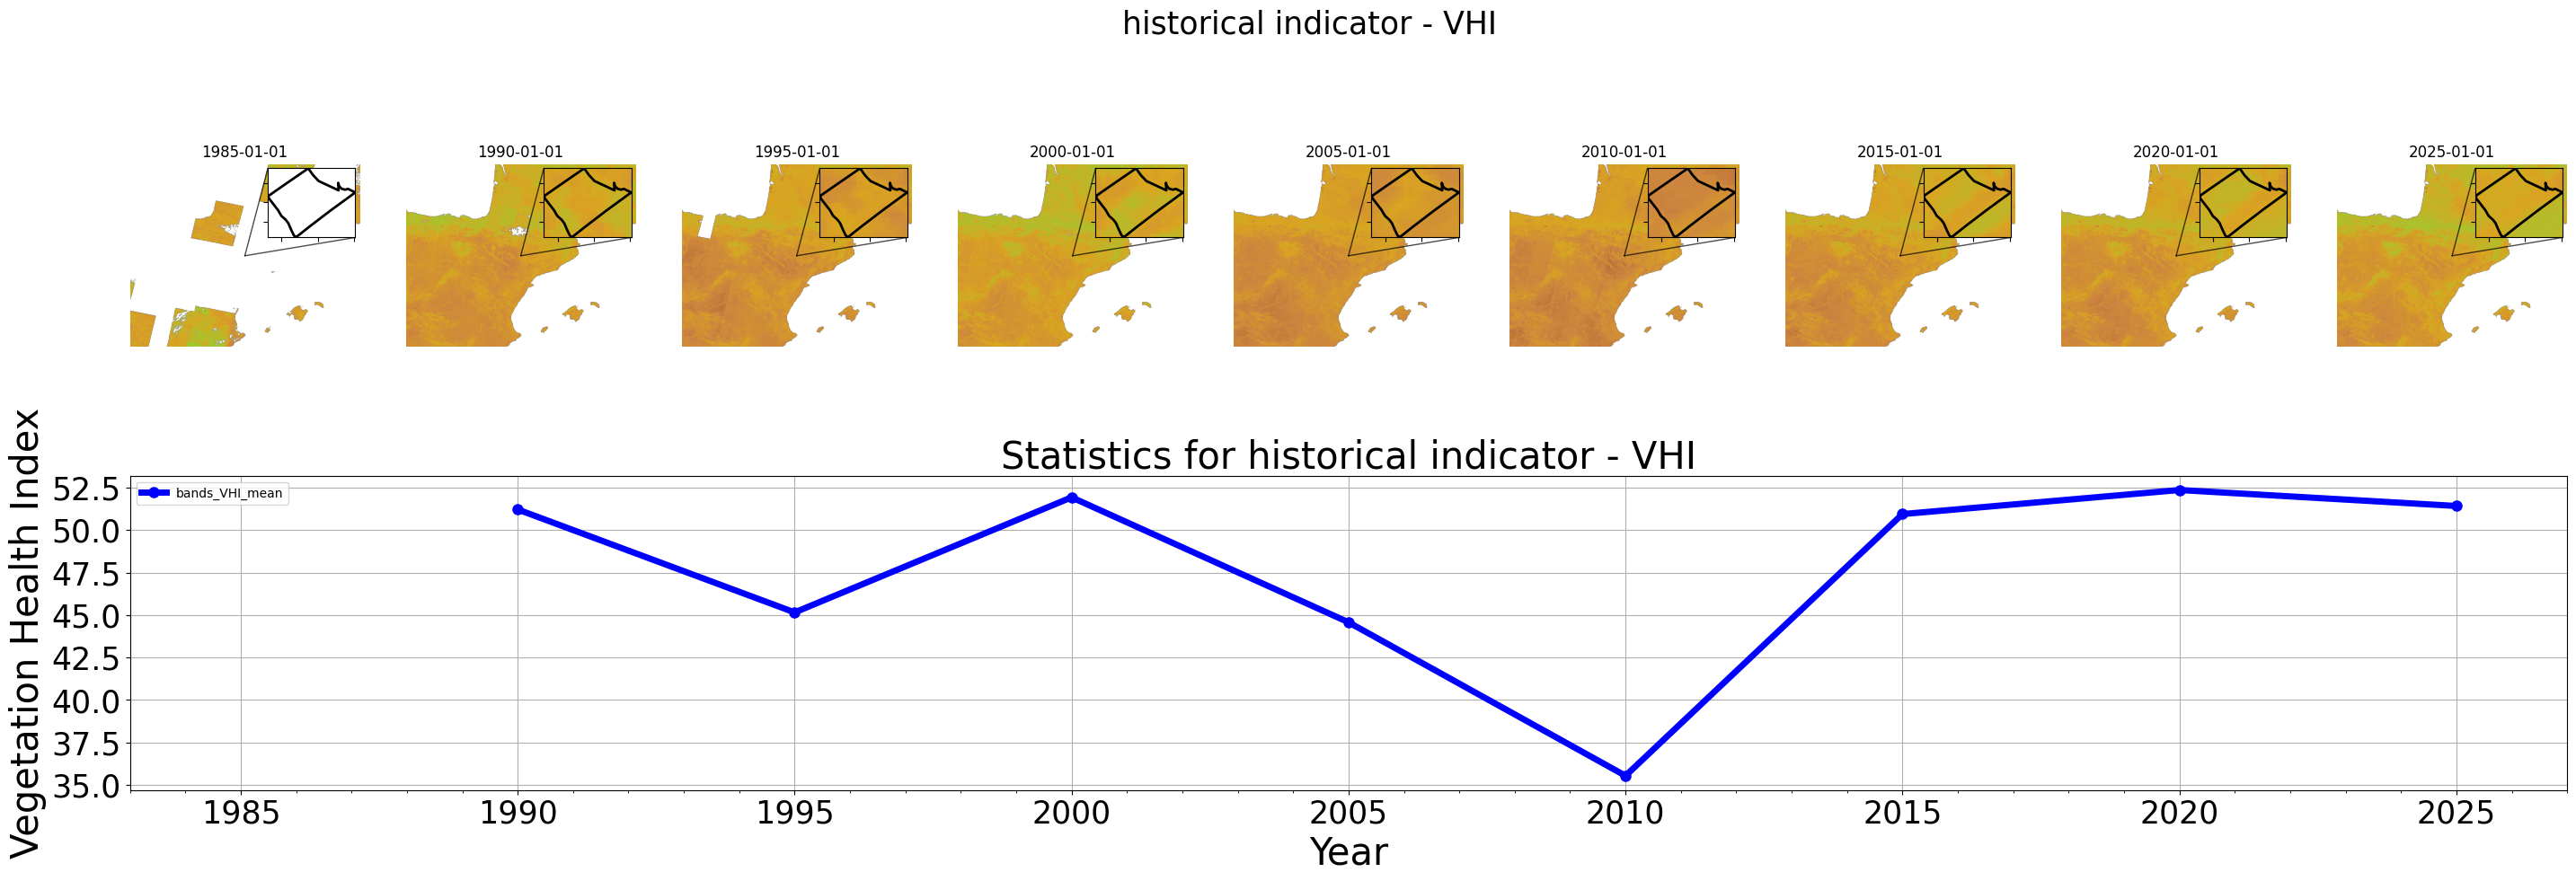

In [20]:
plot_image_with_statistics(stats[0], selected_collections[0], aoi, config)